In [ ]:
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from scipy import constants
import re
import datetime

from Utils import circle_fit_by_taubin, butter_bandpass_filter, normalize_signal, find_vs_peaks, Kalman_filter, HR_RR_Extract_PSD
from FFT_spectrum import *
from RangeAlgorithmv1 import *

# -------------------------------
# User-Defined Parameters
# -------------------------------
folder_path_28 = r'/media/daniel/4TBLacie2/LabXData/actuator_tests_12112024/radar_28_data/actuator_sync_test_v1'
folder_path_70 = r'/media/daniel/4TBLacie2/LabXData/actuator_tests_12112024/radar_70_data/actuator_sync_test_v1'
GUI_on = 1
Adult_on = 1
i_ant = 1    # Antenna index
min_distance = 0.5
max_distance = 3
user_target_bin = 42
plot_during_loop = True  # Set to True to plot each segment during processing
frames_in_window = 3     # Number of frames per segment (no overlap)

def load_data_and_config(folder_path, GUI_on):
    npz_files = [file for file in os.listdir(folder_path) if file.endswith('.npz')]
    npz_abs_file_paths = [os.path.join(folder_path, file) for file in npz_files]
    data_list = []
    timestamps_list = []
    for npz_abs_file_path in npz_abs_file_paths:
        npz_data = np.load(npz_abs_file_path, allow_pickle=True)
        data_part = npz_data['data']
        timestamps_part = npz_data['frame_timestamps_list']
        data_list.append(data_part)
        timestamps_list.append(timestamps_part)
    data = np.concatenate(data_list, axis=0)  
    timestamps = np.concatenate(timestamps_list, axis=0)

    config_file = os.path.join(folder_path, 'config.json')
    if not os.path.exists(config_file):
        raise FileNotFoundError(f"Configuration file not found: {config_file}")
    with open(config_file, 'r') as f:
        device_config = json.load(f)

    # Convert timestamps to seconds if they are datetime
    first_timestamp = timestamps[0]
    if isinstance(first_timestamp, datetime.datetime):
        start_time = first_timestamp
        timestamps = np.array([(t - start_time).total_seconds() for t in timestamps])

    return data, timestamps, device_config

def process_radar(folder_path, GUI_on, Adult_on, i_ant, min_distance, max_distance):
    data, timestamps, device_config = load_data_and_config(folder_path, GUI_on=GUI_on)

    num_frames, num_rx_antennas, num_chirps_per_frame, num_samples_per_chirp = data.shape
    frame_repetition_time_s = device_config['frame_repetition_time_s']
    chirp_repetition_time_s = device_config['chirp_repetition_time_s']
    start_frequency_Hz = device_config['chirp']['start_frequency_Hz']
    end_frequency_Hz = device_config['chirp']['end_frequency_Hz']

    FMCW_Bandwidth = end_frequency_Hz - start_frequency_Hz
    FMCW_lambda = constants.c / ((start_frequency_Hz + end_frequency_Hz) / 2.0)
    range_resolution = constants.c/(2*(FMCW_Bandwidth))
    range_bins = np.linspace(0, range_resolution * num_samples_per_chirp/2, num_samples_per_chirp, endpoint=False)

    min_bin_index = np.searchsorted(range_bins, min_distance)
    max_bin_index = np.searchsorted(range_bins, max_distance)

    rr_match = re.search(r'(\d+)RR', folder_path)
    hr_match = re.search(r'(\d+)HR', folder_path)
    GT_RR = int(rr_match.group(1)) if rr_match else 0
    GT_HR = int(hr_match.group(1)) if hr_match else 0

    motion_threshold = 100

    if Adult_on:
        lowcut_bp = 42/60
        highcut_bp = 180/60 
    else:
        lowcut_bp = 85/60 
        highcut_bp = 220/60 

    # Number of segments based on frames_in_window
    num_segments = num_frames // frames_in_window

    range_map = RangeAlgo(num_samples_per_chirp, frames_in_window * num_chirps_per_frame, start_frequency_Hz, end_frequency_Hz)

    # Arrays to store final concatenated phases and times
    all_phases = []
    all_times = []

    # Variables for HR computations
    rr_bpm_all = []
    hr_bpm_all_wo_adaptive_filter = []
    kalman_hr_all = []
    x_k = None
    P_k = None
    M_no_update = 0

    for seg_idx in range(num_segments):
        frame_start = seg_idx * frames_in_window
        frame_end = frame_start + frames_in_window
        frame_contents = data[frame_start:frame_end, i_ant, :, :]

        mat = frame_contents.reshape(frames_in_window * num_chirps_per_frame, num_samples_per_chirp)

        # Compute Range FFT for this segment
        range_fft, distance_data, distance_peak_idx, distance_peak_m = range_map.compute_range_map(mat, min_bin_index, max_bin_index)

        # Determine target bin
        if isinstance(distance_peak_idx, (list, np.ndarray)) and len(distance_peak_idx) > 0:
            target_bin = distance_peak_idx[0]
        elif isinstance(distance_peak_idx, int):
            target_bin = distance_peak_idx
        else:
            target_bin = min_bin_index

        # Use user-defined bin
        target_bin = user_target_bin
        target_range_bin = range_fft[:, target_bin]

        std_deviation = np.std(np.abs(target_range_bin))
        if std_deviation > motion_threshold:
            continue

        I = target_range_bin.real
        Q = target_range_bin.imag
        params = circle_fit_by_taubin(np.column_stack((I, Q)))
        I_lpf = I - params[0]
        Q_lpf = Q - params[1]

        I_final = I_lpf
        Q_final = Q_lpf

        phase_lpf = np.arctan2(Q_final, I_final)
        phase_lpf_unwrap = np.unwrap(phase_lpf, period=np.pi)

        # Construct time array for this segment
        segment_chirp_times = []
        for f_idx in range(frames_in_window):
            frame_idx_abs = frame_start + f_idx
            frame_time = timestamps[frame_idx_abs]
            chirp_times = frame_time + np.arange(num_chirps_per_frame)*chirp_repetition_time_s
            segment_chirp_times.extend(chirp_times)
        segment_chirp_times = np.array(segment_chirp_times)

        all_phases.append(phase_lpf_unwrap)
        all_times.append(segment_chirp_times)

        # # Optional HR computations
        # displacement = phase_lpf_unwrap * FMCW_lambda / (4*np.pi)
        # displacement = np.sqrt(I_final**2 + Q_final**2)

        # if Adult_on:
        #     displacement_bp_wo_adaptive_filter = butter_bandpass_filter(displacement, 42/60, 180/60, fs=1/chirp_repetition_time_s, order=4)
        # else:
        #     displacement_bp_wo_adaptive_filter = butter_bandpass_filter(displacement, 85/60, 220/60, fs=1/chirp_repetition_time_s, order=4)

        # displacement_bp = butter_bandpass_filter(displacement, lowcut_bp, highcut_bp, fs=1/chirp_repetition_time_s, order=4)
        # displacement_bp_wo_adaptive_filter = normalize_signal(displacement_bp_wo_adaptive_filter)
        # displacement_bp = normalize_signal(displacement_bp)

        # min_peak_height = -5000
        # prominence_hr_peaks = 0.001
        # time_between_peaks = (1/3) if Adult_on else (1/3.75)
        # distance_hr_peaks = int((time_between_peaks)/chirp_repetition_time_s)
        # hr_hz = find_vs_peaks(displacement_bp_wo_adaptive_filter, distance_hr_peaks, min_peak_height, prominence_hr_peaks, chirp_repetition_time_s, plot_on=0)
        # hr_bpm_all_wo_adaptive_filter.append(hr_hz*60)

        # hr_hz = find_vs_peaks(displacement_bp, distance_hr_peaks, min_peak_height, prominence_hr_peaks, chirp_repetition_time_s, plot_on=0)

        # if seg_idx == 0 or x_k is None:
        #     x_k = np.array([[hr_hz, 0.01, 0.01]]).T
        #     P_k = np.identity(3)
        #     M_no_update = 0

        # x_k, P_k, no_update = Kalman_filter(chirp_repetition_time_s, hr_hz, x_k, P_k)
        # M_no_update = M_no_update + no_update if no_update else 0
        # if M_no_update == 0 or M_no_update >= 5:
        #     lowcut_bp = x_k[0] - np.sqrt(P_k[0,0])
        #     highcut_bp = x_k[0] + np.sqrt(P_k[0,0])

        # kalman_hr_all.append(60*x_k[0][0])

        # Plot each segment if enabled
        if plot_during_loop:
            plt.figure()
            plt.plot(segment_chirp_times, phase_lpf_unwrap, label=f'Segment {seg_idx}')
            plt.title(f"Segment {seg_idx}: Phase (Non-overlapping)")
            plt.xlabel("Time [s]")
            plt.ylabel("Unwrapped Phase [rad]")
            plt.grid(True)
            plt.legend()
            plt.show()

    if len(all_phases) == 0:
        return None, None

    all_phases = np.concatenate(all_phases)
    all_times = np.concatenate(all_times)

    return all_times, all_phases

# Process Both Radars
all_times_28, all_phases_28 = process_radar(folder_path_28, GUI_on, Adult_on, i_ant, min_distance, max_distance)
all_times_70, all_phases_70 = process_radar(folder_path_70, GUI_on, Adult_on, i_ant, min_distance, max_distance)

# Plot Phase After Complete Processing
plt.figure(figsize=(10,6))

plotted_something = False

if all_times_28 is not None and all_phases_28 is not None and len(all_times_28) > 0 and len(all_phases_28) > 0:
    plt.plot(all_times_28, all_phases_28, label='Radar 28')
    plotted_something = True

if all_times_70 is not None and all_phases_70 is not None and len(all_times_70) > 0 and len(all_phases_70) > 0:
    plt.plot(all_times_70, all_phases_70, label='Radar 70')
    plotted_something = True

plt.xlabel('Time [s]')
plt.ylabel('Unwrapped Phase [rad]')
plt.title('Unwrapped Phase vs. Time (Non-Overlapping Segments)')
plt.grid(True)

# Only add the legend if we actually plotted something
if plotted_something:
    plt.legend()

plt.show()


## Normalized CC to test if the time sync is optimal. 

Maximum cross-correlation value: 6137.87039391162
Lag (in samples): 0
Time lag (in seconds): 0.0


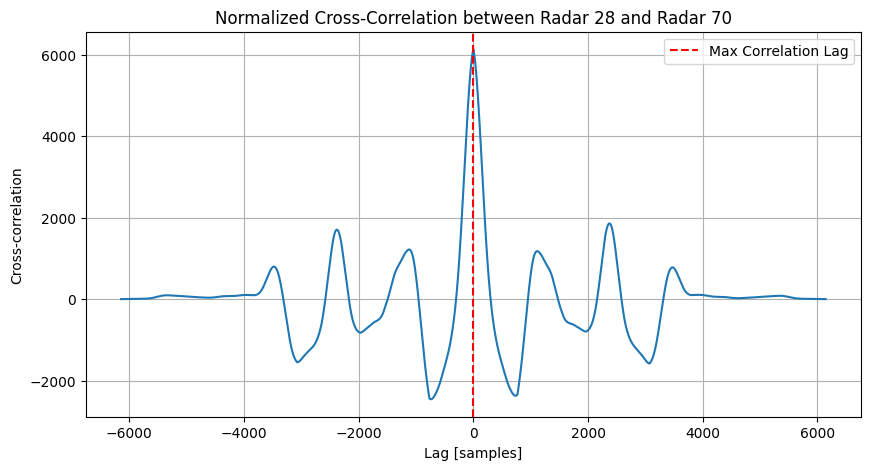

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure that all_times_28, all_phases_28, all_times_70, and all_phases_70 are already defined
if (all_times_28 is None) or (all_times_70 is None) or (all_phases_28 is None) or (all_phases_70 is None):
    raise ValueError("all_times_28, all_phases_28, all_times_70, or all_phases_70 not defined. Please run the previous cell.")

# 1. Identify overlapping time interval
common_start = max(all_times_28[0], all_times_70[0])
common_end = min(all_times_28[-1], all_times_70[-1])

if common_end <= common_start:
    raise ValueError("No overlapping time interval found between the two radars.")

# 2. Focus on the overlapping interval
mask_28 = (all_times_28 >= common_start) & (all_times_28 <= common_end)
mask_70 = (all_times_70 >= common_start) & (all_times_70 <= common_end)

times_28_overlap = all_times_28[mask_28]
phases_28_overlap = all_phases_28[mask_28]

# Interpolate radar 70 data onto radar 28's time base
phases_70_interp = np.interp(times_28_overlap, all_times_70[mask_70], all_phases_70[mask_70])

# 3. Normalize both signals (mean 0, std 1)
phases_28_norm = (phases_28_overlap - np.mean(phases_28_overlap)) / np.std(phases_28_overlap)
phases_70_norm = (phases_70_interp - np.mean(phases_70_interp)) / np.std(phases_70_interp)

# 4. Compute cross-correlation
# 'full' mode correlation returns array of length (N+N-1)
corr = np.correlate(phases_28_norm, phases_70_norm, mode='full')
lags = np.arange(-(len(phases_70_norm)-1), len(phases_28_norm))

# 5. Find the lag with maximum correlation
max_corr_index = np.argmax(corr)
max_corr_value = corr[max_corr_index]
time_lag = lags[max_corr_index] * (times_28_overlap[1] - times_28_overlap[0])  # Convert sample lag to time lag

print(f"Maximum cross-correlation value: {max_corr_value}")
print(f"Lag (in samples): {lags[max_corr_index]}")
print(f"Time lag (in seconds): {time_lag}")

# Plot correlation vs lag
plt.figure(figsize=(10,5))
plt.plot(lags, corr)
plt.axvline(x=lags[max_corr_index], color='r', linestyle='--', label='Max Correlation Lag')
plt.title('Normalized Cross-Correlation between Radar 28 and Radar 70')
plt.xlabel('Lag [samples]')
plt.ylabel('Cross-correlation')
plt.legend()
plt.grid(True)
plt.show()

# Interpret results:
# If time_lag ~ 0, radars are well aligned.
# A positive time_lag means Radar 70 leads Radar 28 by that many seconds.
# A negative time_lag means Radar 28 leads Radar 70 by that many seconds.


### NNC with an artificial shift of 1 chrip. 

Original (No Artificial Shift):
Max NCC Value: 6137.870, Lag (samples): 0, Lag (seconds): 0.000000


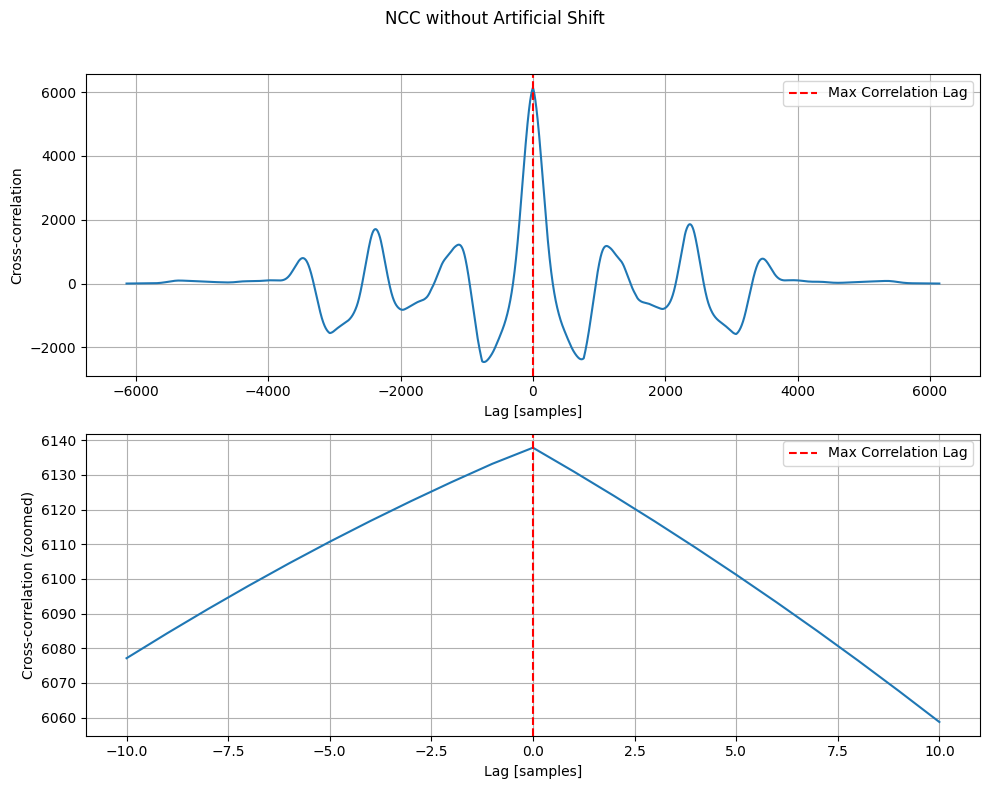


With Artificial One-Sample Shift in Radar 70:
Max NCC Value: 6137.851, Lag (samples): -1, Lag (seconds): -0.005001


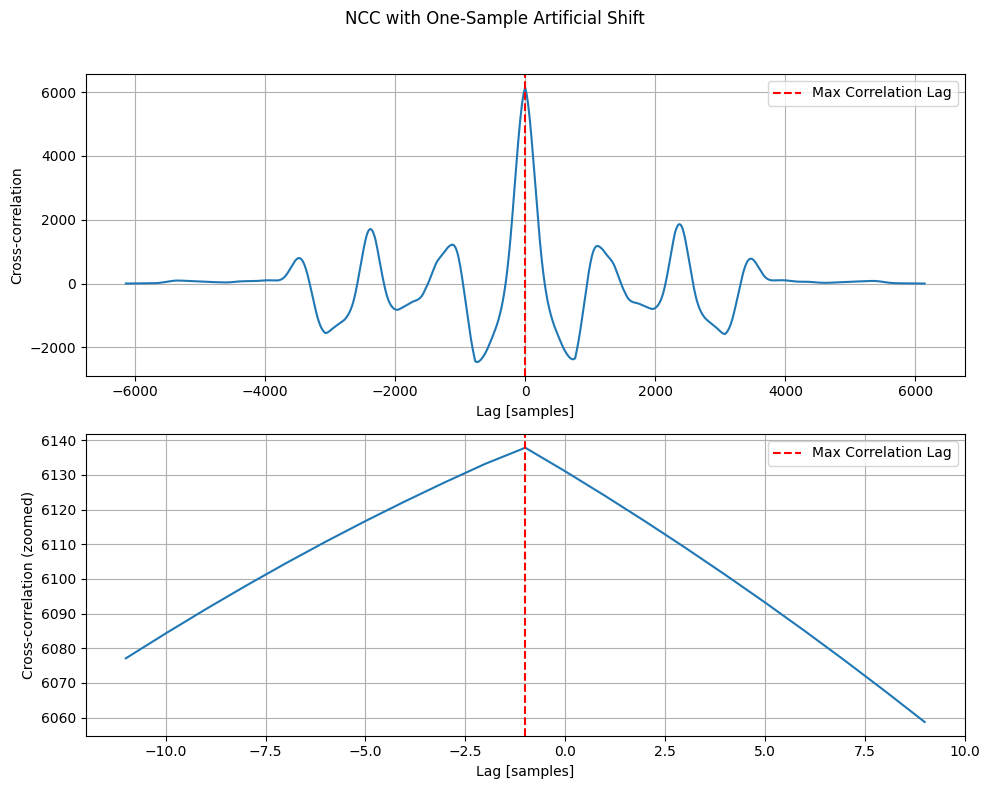

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Check for required variables
if (all_times_28 is None) or (all_times_70 is None) or (all_phases_28 is None) or (all_phases_70 is None):
    raise ValueError("all_times_28, all_phases_28, all_times_70, or all_phases_70 not defined.")

# Identify the overlapping time interval
common_start = max(all_times_28[0], all_times_70[0])
common_end = min(all_times_28[-1], all_times_70[-1])
if common_end <= common_start:
    raise ValueError("No overlapping time interval found between the two radars.")

# Focus on overlapping interval
mask_28 = (all_times_28 >= common_start) & (all_times_28 <= common_end)
mask_70 = (all_times_70 >= common_start) & (all_times_70 <= common_end)

times_28_overlap = all_times_28[mask_28]
phases_28_overlap = all_phases_28[mask_28]

# Interpolate Radar 70 data onto Radar 28's time base
phases_70_interp = np.interp(times_28_overlap, all_times_70[mask_70], all_phases_70[mask_70])

# Compute the time step
time_step = np.mean(np.diff(times_28_overlap))

# Normalize both signals
phases_28_norm = (phases_28_overlap - np.mean(phases_28_overlap)) / np.std(phases_28_overlap)
phases_70_norm = (phases_70_interp - np.mean(phases_70_interp)) / np.std(phases_70_interp)

# Original correlation
corr = np.correlate(phases_28_norm, phases_70_norm, mode='full')
lags = np.arange(-(len(phases_70_norm)-1), len(phases_28_norm))
max_corr_index = np.argmax(corr)
max_corr_value = corr[max_corr_index]
time_lag = lags[max_corr_index] * time_step

print("Original (No Artificial Shift):")
print(f"Max NCC Value: {max_corr_value:.3f}, Lag (samples): {lags[max_corr_index]}, Lag (seconds): {time_lag:.6f}")

# Plot original correlation: full and zoomed
fig, (ax_full, ax_zoom) = plt.subplots(2, 1, figsize=(10,8))
fig.suptitle('NCC without Artificial Shift')

# Full plot
ax_full.plot(lags, corr)
ax_full.axvline(lags[max_corr_index], color='r', linestyle='--', label='Max Correlation Lag')
ax_full.set_xlabel('Lag [samples]')
ax_full.set_ylabel('Cross-correlation')
ax_full.grid(True)
ax_full.legend()

# Zoomed plot around max lag
zoom_radius = 10  # number of samples around max lag to show
lag_min = lags[max_corr_index] - zoom_radius
lag_max = lags[max_corr_index] + zoom_radius
mask_zoom = (lags >= lag_min) & (lags <= lag_max)

ax_zoom.plot(lags[mask_zoom], corr[mask_zoom])
ax_zoom.axvline(lags[max_corr_index], color='r', linestyle='--', label='Max Correlation Lag')
ax_zoom.set_xlabel('Lag [samples]')
ax_zoom.set_ylabel('Cross-correlation (zoomed)')
ax_zoom.grid(True)
ax_zoom.legend()

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

# -------------------------------------------------------
# Introduce an artificial shift of one sample
# -------------------------------------------------------
one_sample_shift = 1  # shift by 1 sample
phases_70_shifted = np.roll(phases_70_norm, one_sample_shift)

corr_shifted = np.correlate(phases_28_norm, phases_70_shifted, mode='full')
lags_shifted = np.arange(-(len(phases_70_shifted)-1), len(phases_28_norm))
max_corr_index_shifted = np.argmax(corr_shifted)
max_corr_value_shifted = corr_shifted[max_corr_index_shifted]
time_lag_shifted = lags_shifted[max_corr_index_shifted] * time_step

print("\nWith Artificial One-Sample Shift in Radar 70:")
print(f"Max NCC Value: {max_corr_value_shifted:.3f}, Lag (samples): {lags_shifted[max_corr_index_shifted]}, Lag (seconds): {time_lag_shifted:.6f}")

# Plot shifted correlation: full and zoomed
fig, (ax_full_shifted, ax_zoom_shifted) = plt.subplots(2, 1, figsize=(10,8))
fig.suptitle('NCC with One-Sample Artificial Shift')

# Full plot
ax_full_shifted.plot(lags_shifted, corr_shifted)
ax_full_shifted.axvline(lags_shifted[max_corr_index_shifted], color='r', linestyle='--', label='Max Correlation Lag')
ax_full_shifted.set_xlabel('Lag [samples]')
ax_full_shifted.set_ylabel('Cross-correlation')
ax_full_shifted.grid(True)
ax_full_shifted.legend()

# Zoomed plot around max lag for shifted scenario
lag_min_shifted = lags_shifted[max_corr_index_shifted] - zoom_radius
lag_max_shifted = lags_shifted[max_corr_index_shifted] + zoom_radius
mask_zoom_shifted = (lags_shifted >= lag_min_shifted) & (lags_shifted <= lag_max_shifted)

ax_zoom_shifted.plot(lags_shifted[mask_zoom_shifted], corr_shifted[mask_zoom_shifted])
ax_zoom_shifted.axvline(lags_shifted[max_corr_index_shifted], color='r', linestyle='--', label='Max Correlation Lag')
ax_zoom_shifted.set_xlabel('Lag [samples]')
ax_zoom_shifted.set_ylabel('Cross-correlation (zoomed)')
ax_zoom_shifted.grid(True)
ax_zoom_shifted.legend()

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

# Interpretation:
# Compare the peak location and NCC value before and after the artificial shift.
# The zoomed-in plots help visualize subtle changes in the correlation peak due to a single-chirp shift.
